# Aula 3_4 - BERT

Nome: Maria Fernanda Bosco  
RA: 183544

## Instruções:

Criar um modelo de linguagem e medir a perplexidade utilizando o dataset do Machado de Assis, utilizando Embeddings gerados por um BERT pré-treinado e uma MLP.

- Deve-se implementar o próprio laço de treinamento. **Não usar frameworks de treinamento automático.**
- Utilizar o BertModel.from_pretrained e BertTokenizer.from_pretrained do Hugging Face para carregar o BERT pré-treinado.
- Não utilize outras classes da HuggingFace/Transformers alem da [BertModel](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel) e [BertTokenizer](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer).
- Trabalhe no espaço dos tokens/inteiros. Uma forma de fazer isso é tokenizar o dataset inteiro como pré-processamento.
- Experimente com aumentar o contexto e congelar ou não os parâmetros do BERT. Cuidado que o contexto é o maior fator para o peso computacional aqui.
- **Sugerimos utilizar um BERT PEQUENO como o [bert-tiny](https://huggingface.co/prajjwal1/bert-tiny)**
- Inicialmente utilizar o embedding de saída do último token para prever a próxima palavra. Podem experimentar com outras formas de usar o Embedding.
- MLP deve utilizar o vocab_size do BERT na saída. Isso gera um grande desafio de manter o tamanho da MLP razoável. Dica: use uma quantidade de neurônios bem pequena na camada intermediária.
- Deixe para usar GPU somente quando tudo estiver validado.

In [ ]:
import random
import torch
import torch.nn.functional as F
import numpy as np
from transformers import BertTokenizer, BertModel
import torchinfo
import time

import os
import re
import matplotlib.pyplot as plt
import math
from typing import List
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

# Dados

Limpeza de dados feita com base na implementada pelo aluno **Pedro Rebollo** no notebook da [Aula_2-Auto-Atenção](Pedro_Rebollo-Aula_2-Auto_Atenção.ipynb)

In [ ]:
import os
# >>> Análise varia dependendo do formato que os dados são fornecidos <<<

DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

# Abrir arquito textual e ler os dados originais
with open(DATA_PATH, "r") as data_file:
    data_text = data_file.read()

# Número total de caracteres no dataset
len(data_text)

18845445

In [ ]:
# Ler e limpar dados
with open(DATA_PATH, "r") as data_file:
    cleaned_lines = [line.strip().lower() for line in data_file if line.strip()]

print(f"Total de linhas: {len(cleaned_lines)}")
print(f"Exemplo: {random.choice(cleaned_lines)}")

Total de linhas: 305276
Exemplo: esperança. familiarizado com helena, tratado por ela com esquisita atenção, era contudo a


ANÁLISE DOS DADOS
Antes da limpeza: {'n_lines': 305276, 'mean_len_chars': 60.72877003105386, 'p50_len_chars': 72, 'p90_len_chars': 93, 'min_len_chars': 1, 'max_len_chars': 505}
Exemplo bruto: Já?
Depois da limpeza: {'n_lines': 244127, 'mean_len_chars': 74.17483113297587, 'p50_len_chars': 81, 'p90_len_chars': 98, 'min_len_chars': 11, 'max_len_chars': 1009}
Exemplo limpo: tentado empregála em português , nem talvez seja coisa que mereça trasladação . a forma entretanto é graciosa e não


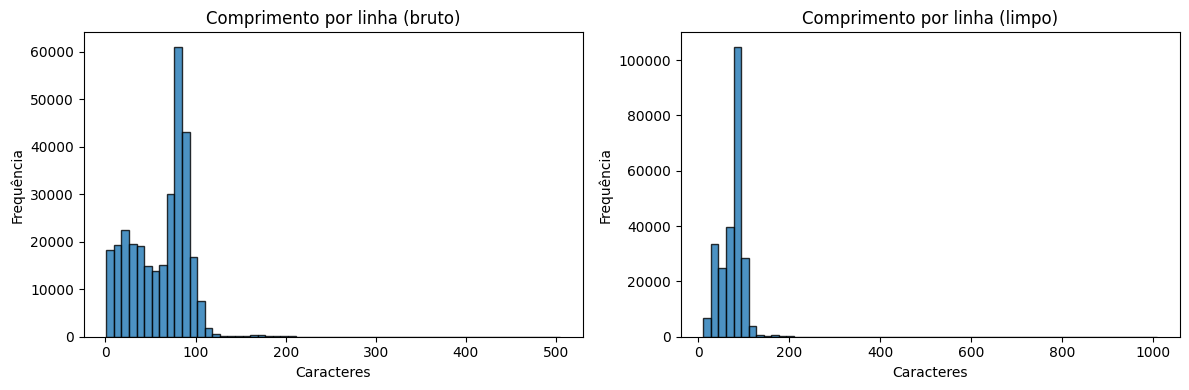

Linhas de treino: 195301 | Linhas de validação: 48826


In [ ]:
import unicodedata
from collections import Counter
import re
import numpy as np
# ================================
# PIPELINE DE LIMPEZA E ANÁLISE
# ================================

def normalize_unicode(text):
    """Normaliza o texto para a forma NFKC e substitui aspas e travessões."""
    text = unicodedata.normalize("NFKC", text)
    text = text.replace(""", '"').replace(""", '"').replace("'", "'").replace("'", "'")
    text = text.replace("–", "-").replace("—", "-")
    return text

def remove_accents(text):
    """Remove acentos do texto."""
    return "".join(
        c for c in unicodedata.normalize("NFD", text)
        if unicodedata.category(c) != "Mn"
    )

def basic_clean(text, lower=True, strip_accents=False):
    """Limpeza básica do texto (normaliza, coloca tudo em minúsculo, separa pontuação e remove acentos)"""
    t = normalize_unicode(text)
    if strip_accents:
        t = remove_accents(t)
    if lower:
        t = t.lower()
    t = re.sub(r"\s+", " ", t)
    t = re.sub(r"([,.!?;:()\"'])", r" \1 ", t)
    t = re.sub(r"-", " - ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def replace_numbers(text, strategy="token"):  # "keep" | "token" | "remove"
    """Substitui números por <NUM> ou remove-os."""
    if strategy == "keep":
        return text
    if strategy == "token":
        return re.sub(r"\b\d+([.,]\d+)?\b", "<NUM>", text)
    if strategy == "remove":
        return re.sub(r"\b\d+([.,]\d+)?\b", "", text)
    return text

def tokenize(text):
    """Divide o texto em tokens (palavras)."""
    return text.split()

def analyze_lengths(lines):
    """Analise estatísticas de comprimento das linhas."""
    lens = [len(l) for l in lines]
    return {
        "n_lines": len(lines),
        "mean_len_chars": float(np.mean(lens)) if lens else 0.0,
        "p50_len_chars": int(np.percentile(lens, 50)) if lens else 0,
        "p90_len_chars": int(np.percentile(lens, 90)) if lens else 0,
        "min_len_chars": min(lens) if lens else 0,
        "max_len_chars": max(lens) if lens else 0,
    }

def deduplicate(lines, max_dups=2):
    """Remove duplicatas, mantendo no máximo `max_dups` ocorrências de cada linha."""
    counts = Counter(lines)
    deduped, seen = [], Counter()
    for l in lines:
        if seen[l] < min(max_dups, counts[l]):
            deduped.append(l); seen[l] += 1
    return deduped

# 1) Carregar linhas brutas
with open(DATA_PATH, "r") as f:
    raw_lines = [ln.strip() for ln in f if ln.strip()]

print("="*50)
print("ANÁLISE DOS DADOS")
print("="*50)
print("Antes da limpeza:", analyze_lengths(raw_lines))
print("Exemplo bruto:", random.choice(raw_lines))

# 2) Limpeza configurável
lower = True
strip_accents = False       # experimente True se houver variação de acento
number_strategy = "token"   # "keep" | "token" | "remove"
min_tokens_per_line = 6     # mínimo de 8 tokens por linha

cleaned = []
for ln in raw_lines:
    ln2 = basic_clean(ln, lower=lower, strip_accents=strip_accents)
    ln2 = replace_numbers(ln2, strategy=number_strategy)
    toks = tokenize(ln2)
    if len(toks) >= min_tokens_per_line:
        cleaned.append(" ".join(toks))

# 3) Deduplicação suave
cleaned = deduplicate(cleaned, max_dups=2)

print("Depois da limpeza:", analyze_lengths(cleaned))
print("Exemplo limpo:", random.choice(cleaned))

# 3.1) Histogramas de comprimento (antes/depois)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Comprimento por linha (bruto)")
plt.hist([len(x) for x in raw_lines], bins=60, alpha=0.8, edgecolor="black")
plt.xlabel("Caracteres")
plt.ylabel("Frequência")
plt.subplot(1,2,2)
plt.title("Comprimento por linha (limpo)")
plt.hist([len(x) for x in cleaned], bins=60, alpha=0.8, edgecolor="black")
plt.xlabel("Caracteres")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

# 4) Split treino/val
shuffled_lines = cleaned.copy()
random.shuffle(shuffled_lines)

limit = int(0.8 * len(shuffled_lines))
train_cleaned_lines = shuffled_lines[:limit]
val_cleaned_lines = shuffled_lines[limit:]


print(f"Linhas de treino: {len(train_cleaned_lines)} | Linhas de validação: {len(val_cleaned_lines)}")


In [ ]:
train_cleaned_lines[0]

'ela escutava , ele falava ; depois era o contrário , ela é que falava , ele é que ouvia , tão'

In [ ]:
val_cleaned_lines[0]

'mesma , outra e novíssima teoria .'

# BERT

## Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer_tiny = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')

In [ ]:
input_str = train_cleaned_lines[0]
tokenizer(input_str)

{'input_ids': [101, 740, 13083, 5723, 117, 368, 18402, 132, 700, 495, 146, 3811, 117, 740, 253, 179, 18402, 117, 368, 253, 179, 8362, 22278, 117, 2514, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.tokenize(input_str)

['ela',
 'escu',
 '##tava',
 ',',
 'ele',
 'falava',
 ';',
 'depois',
 'era',
 'o',
 'contrário',
 ',',
 'ela',
 'é',
 'que',
 'falava',
 ',',
 'ele',
 'é',
 'que',
 'ouvi',
 '##a',
 ',',
 'tão']

In [ ]:
tokenizer_tiny(input_str)

{'input_ids': [101, 3449, 2050, 9686, 12690, 12462, 1010, 3449, 2063, 6904, 14973, 2050, 1025, 2139, 6873, 2483, 3690, 1051, 24528, 9488, 1010, 3449, 2050, 1041, 10861, 6904, 14973, 2050, 1010, 3449, 2063, 1041, 10861, 15068, 9035, 1010, 20216, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer_tiny.tokenize(input_str)

['el',
 '##a',
 'es',
 '##cut',
 '##ava',
 ',',
 'el',
 '##e',
 'fa',
 '##lav',
 '##a',
 ';',
 'de',
 '##po',
 '##is',
 'era',
 'o',
 'contra',
 '##rio',
 ',',
 'el',
 '##a',
 'e',
 'que',
 'fa',
 '##lav',
 '##a',
 ',',
 'el',
 '##e',
 'e',
 'que',
 'ou',
 '##via',
 ',',
 'tao']

## Forward no modelo

In [ ]:
# O BERT TINY é a mesma coisa, só escalado para muito menos camadas!
model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
model_tiny = BertModel.from_pretrained('prajjwal1/bert-tiny')

test_input = tokenizer("Hello BERT!", return_tensors='pt').input_ids
test_input

tensor([[  101, 15044, 22280,   241,  5054, 22321,   106,   102]])

In [ ]:
torchinfo.summary(model,
                  input_data=test_input,
                  depth=3)

Layer (type:depth-idx)                                  Output Shape              Param #
BertModel                                               [1, 768]                  --
├─BertEmbeddings: 1-1                                   [1, 8, 768]               --
│    └─Embedding: 2-1                                   [1, 8, 768]               22,881,792
│    └─Embedding: 2-2                                   [1, 8, 768]               1,536
│    └─Embedding: 2-3                                   [1, 8, 768]               393,216
│    └─LayerNorm: 2-4                                   [1, 8, 768]               1,536
│    └─Dropout: 2-5                                     [1, 8, 768]               --
├─BertEncoder: 1-2                                      [1, 8, 768]               --
│    └─ModuleList: 2-6                                  --                        --
│    │    └─BertLayer: 3-1                              [1, 8, 768]               7,087,872
│    │    └─BertLayer: 3-2        

In [ ]:
model.config.max_position_embeddings

512

In [ ]:
print("Tamanho do vocabulário do BERT:", tokenizer.vocab_size)

Tamanho do vocabulário do BERT: 29794


In [ ]:
torchinfo.summary(model_tiny)

Layer (type:depth-idx)                                  Param #
BertModel                                               --
├─BertEmbeddings: 1-1                                   --
│    └─Embedding: 2-1                                   3,906,816
│    └─Embedding: 2-2                                   65,536
│    └─Embedding: 2-3                                   256
│    └─LayerNorm: 2-4                                   256
│    └─Dropout: 2-5                                     --
├─BertEncoder: 1-2                                      --
│    └─ModuleList: 2-6                                  --
│    │    └─BertLayer: 3-1                              198,272
│    │    └─BertLayer: 3-2                              198,272
├─BertPooler: 1-3                                       --
│    └─Linear: 2-7                                      16,512
│    └─Tanh: 2-8                                        --
Total params: 4,385,920
Trainable params: 4,385,920
Non-trainable params: 0

In [ ]:
model_tiny.config.max_position_embeddings

512

In [ ]:
print("Tamanho do vocabulário do BERT:", tokenizer_tiny.vocab_size)

Tamanho do vocabulário do BERT: 30522


In [ ]:
V = 30000
D = 128

torch.nn.Linear(D, V, bias=False)

Linear(in_features=128, out_features=30000, bias=False)

In [ ]:
V*D

3840000

In [ ]:
R = 16

fc1 = torch.nn.Linear(D, R, bias=False)
fc2 = torch.nn.Linear(R, V, bias=False)

In [ ]:
D*R + R*V

482048

## Classe do dataset

Utilize o Tokenizer do Bert na classe Dataset.
Defina um tamanho de sequencia/contexto.

In [ ]:
context_size = 5 # 5 palavras de entrada. O target é a próxima palavra
"""TODO: Preparar o dataset"""

In [ ]:
# Tokenizando dataset partir do BERT
def tokenize_lines(lines, tokenizer, max_length=None):
    """
    Tokeniza uma lista de linhas usando o tokenizer do BERT.
    Retorna uma lista de listas de ids de tokens.
    """
    tokenized = []
    for line in lines:
        # Tokeniza sem truncar, adicionando tokens especiais
        encoded = tokenizer.encode(
            line,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True if max_length else False
        )
        tokenized.append(encoded)
    return tokenized

# Tokenizar datasets de treino e validação
train_tokenized = tokenize_lines(train_cleaned_lines, tokenizer)
val_tokenized = tokenize_lines(val_cleaned_lines, tokenizer)

In [ ]:
# Imprimindo exemplo com de/para do treino antes e após a tokenização
print("Exemplo de treino antes da tokenização:", train_cleaned_lines[0])
print("Exemplo de treino após a tokenização:", train_tokenized[0])

Exemplo de treino antes da tokenização: ela escutava , ele falava ; depois era o contrário , ela é que falava , ele é que ouvia , tão
Exemplo de treino após a tokenização: [101, 740, 13083, 5723, 117, 368, 18402, 132, 700, 495, 146, 3811, 117, 740, 253, 179, 18402, 117, 368, 253, 179, 8362, 22278, 117, 2514, 102]


In [ ]:
# Imprimindo exemplo com de/para da validação antes e após a tokenização
print("Exemplo de validação antes da tokenização:", val_cleaned_lines[0])
print("Exemplo de validação após a tokenização:", val_tokenized[0])

Exemplo de validação antes da tokenização: mesma , outra e novíssima teoria .
Exemplo de validação após a tokenização: [101, 1589, 117, 1858, 122, 891, 10916, 3025, 119, 102]


In [ ]:
def create_xy_pairs(tokenized_lines, context_size, sep_token_id=101):
    """
    Cria pares (X, Y) a partir de uma lista de listas de tokens.
    X: lista de context_size tokens (contexto)
    Y: token alvo (próximo token)
    Não inclui pares onde Y == sep_token_id ([SEP] do BERT).
    """
    X, Y = [], []
    for tokens in tokenized_lines:
        # Garante que há contexto + target
        for i in range(context_size, len(tokens)):
            x = tokens[i-context_size:i]
            y = tokens[i]
            if y == sep_token_id:
                continue
            X.append(x)
            Y.append(y)
    return X, Y

context_size = 5
X_train, Y_train = create_xy_pairs(train_tokenized, context_size)
X_val, Y_val = create_xy_pairs(val_tokenized, context_size)

print(f"Pares de treino: {len(X_train)} | Pares de validação: {len(X_val)}")

Pares de treino: 3092620 | Pares de validação: 773009


In [ ]:
# exemplo de par X,Y
X_train[0], Y_train[0]

([101, 740, 13083, 5723, 117], 368)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MachadoDataset(Dataset):
    def __init__(self, sentences, tokenizer, context_size=5, max_length=128):
        self.sentences = sentences
        self.context_size = context_size
        self.tokenizer = tokenizer
        self.max_length = max_length # max length for padding/truncation

        # Tokeniza as sentenças a partir de tokenizer do BERT
        #self.encoded = self.tokenizer(self.sentences, padding=True, truncation=True, return_tensors="pt")
        self.encoded = tokenize_lines(self.sentences, self.tokenizer, max_length=self.max_length)

        # Cria pares (X, Y) a partir dos tokens
        self.X, self.Y = create_xy_pairs(self.encoded, self.context_size)

        # Converte para tensores
        self.X = torch.tensor([[x for x in ctx] for ctx in self.X], dtype=torch.long)
        self.Y = torch.tensor([y for y in self.Y], dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer_tiny = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')

context_size = 5

testdb = MachadoDataset(
    [("dom casmurro e um homem muito astuto")], tokenizer_tiny, context_size=context_size
    )
print(testdb[0][0])
print(testdb[0][1])
print(tokenizer.decode(testdb[0][0]))
print(tokenizer.decode(testdb[0][1]))

tensor([  101, 14383, 25222, 20136,  3217])
tensor(1041)
[CLS] LucianoȖântico Real
lon


In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer_tiny = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
context_size = 5

train_dataset = MachadoDataset(train_cleaned_lines, tokenizer, context_size=context_size)
val_dataset = MachadoDataset(val_cleaned_lines, tokenizer, context_size=context_size)

train_dataset_tiny = MachadoDataset(train_cleaned_lines, tokenizer_tiny, context_size=context_size)
val_dataset_tiny = MachadoDataset(val_cleaned_lines, tokenizer_tiny, context_size=context_size)

## DataLoader

In [ ]:
batch_size = 2048      # tamanho do batch

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
sample = next(iter(train_loader))

# Model

In [ ]:
import torch.nn as nn

class LanguageModel(torch.nn.Module):
    def __init__(
            self,
            hidden_dim=16, # utilizando qtd pequena de neuronios na camada intermediaria
            model_name = "mrm8488/bert-tiny-portuguese", # BERT tiny em portugues (nao rolou)
            frozen_bert=True
        ):
        super(LanguageModel, self).__init__()

        # Carregando BERT pre-treinado
        self.bert = BertModel.from_pretrained(model_name)

        # Calculando tamanho do vocabulário
        #self.vocab_size = self.bert.config.vocab_size

        # Congelando parametros do BERT
        if frozen_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        else:
            for param in self.bert.parameters():
                param.requires_grad = True

        # Camada MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, hidden_dim), # aqui vai reduzir a saida do BERT para hidden_dim
            nn.ReLU(),
            nn.Linear(hidden_dim, self.bert.config.vocab_size)   # aqui a saída será do tamanho do vocab do BERT
        )

    def forward(self, input_ids, attention_mask=None):
        """
        input_ids = <tensor com os ids dos tokens de entrada> [batch_size, seq_len]
        attention_mask = <tensor com a máscara de atenção> [batch_size, seq_len] precisa disso?

        return logits: <tensor com as previsões do modelo> [batch_size, vocab_size]
        """
        # BERT forward pass
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Ultima camada oculta
        last_hidden_state = outputs.last_hidden_state

        # Passando pela MLP
        # Pega o último token da sequência, por isso [:,-1,:]
        logits = self.mlp(last_hidden_state[:, -1, :])

        return logits


In [ ]:
model = LanguageModel(
    hidden_dim=16,
    #model_name='prajjwal1/bert-tiny',
    model_name="neuralmind/bert-base-portuguese-cased",
    frozen_bert=True
)

sample = next(iter(train_loader))
input = sample[0]
target = sample[1]

In [ ]:
output = model(input)

In [ ]:
output.shape

torch.Size([2048, 29794])

In [ ]:
output.argmax(dim=1)

tensor([19804,  9024,  1827,  ..., 21367, 21584, 23442])

In [ ]:
target

tensor([ 117,  226,  125,  ...,  528, 3179,  221])

In [ ]:
torchinfo.summary(model)

Layer (type:depth-idx)                                       Param #
LanguageModel                                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   (22,881,792)
│    │    └─Embedding: 3-2                                   (393,216)
│    │    └─Embedding: 3-3                                   (1,536)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Sequential: 1-2                                      

# Training

## Definindo device

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device

device(type='cpu')

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


## Definindo funções de treino e validação

In [ ]:
# define finçao de treinamento e validação
def train_batch(model, X, Y, optimizer, criterion, device):
    model.train()

    # X, Y = data
    X, Y = X.to(device), Y.to(device)

    # forward pass
    output = model(X)
    # ajustando dimensoes, pois saida terá shape [batch_size, context_size, vocab_size]
    #output = output[:, -1, :]  # [B, V]
    #loss = criterion(output, Y)  # Y com shape [B]
    loss = criterion(output, Y)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def validate_batch(model, X, Y, criterion, device):
    model.eval()

    # X, Y = data
    X, Y = X.to(device), Y.to(device)

    output = model(X)  # [B, L, V]
    #output = output[:, -1, :]  # [B, V]
    loss = criterion(output, Y)  # Y com shape [B]

    return loss.item()

In [ ]:
# define função de treinamento do modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience=3):
    # Validação inicial
    vocab_size = model.mlp[-1].out_features

    def validate_indices(loader, split_name):
        for batch_idx, (X, Y) in enumerate(loader):
            if X.max() >= vocab_size:
                raise ValueError(
                    f"Batch {batch_idx} em {split_name} tem índice {X.max()} >= vocab_size {vocab_size}")
            if Y.max() >= vocab_size:
                raise ValueError(
                    f"Batch {batch_idx} em {split_name} tem target {Y.max()} >= vocab_size {vocab_size}")

    print("Validando índices...")
    validate_indices(train_loader, "train")
    validate_indices(val_loader, "val")
    print("Validação ok!")

    # treinamento
    model.to(device)

    losses_train = []  # losses for plotting
    losses_val = []  # losses for plotting

    perplexities_train = []  # perplexities for plotting
    perplexities_val = []  # perplexities for plotting

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        N = len(train_loader)  # number of batches
        train_loss = 0.0
        val_loss = 0.0
        start_time = time.time()

        model.train()
        for batch in train_loader:
            X, Y = batch  # Unpack the batch first
            batch_loss = train_batch(model, X, Y, optimizer, criterion, device)
            train_loss += batch_loss

        epoch_loss = train_loss / N  # average loss for the epoch
        losses_train.append(epoch_loss)
        # perplexity is the exponential of the loss
        epoch_perplexity = np.exp(epoch_loss)
        perplexities_train.append(epoch_perplexity)

        epoch_duration = time.time() - start_time

        N = len(val_loader)  # number of batches
        model.eval()
        for batch in val_loader:
            X, Y = batch  # Unpack the batch first
            batch_loss = validate_batch(model, X, Y, criterion, device)
            val_loss += batch_loss

        epoch_loss_val = val_loss / N  # average loss for the epoch
        losses_val.append(epoch_loss_val)
        # perplexity is the exponential of the loss
        epoch_perplexity_val = np.exp(epoch_loss_val)
        perplexities_val.append(epoch_perplexity_val)

        print(f'Epoch [{epoch+1}/{epochs}] | ',
              f'Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_loss_val:.4f} | ',
              f'Train Perplexity: {epoch_perplexity:.4f} | Val Perplexity: {epoch_perplexity_val:.4f} | ',
              f'Time: {epoch_duration:.2f}s')

        # Early stopping
        if epoch_loss_val < best_val_loss:
            best_val_loss = epoch_loss_val
            patience_counter = 0
            # Se quiser salvar o melhor modelo:
            # torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(
                    f"Early stopping em {epoch+1} épocas! Melhor val_loss: {best_val_loss:.4f}")
                break

    return losses_train, losses_val, perplexities_train, perplexities_val, model

## Perplexidade Inicial

In [ ]:
# hiperparametros
epochs = 5
lr = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [ ]:
# Calcula a loss e perplexidade iniciais no conjunto de treinamento
model.to(device)
model.eval()
train_loss = 0.0
N = len(train_loader)
for X, Y in train_loader:
    X, Y = X.to(device), Y.to(device)
    output = model(X)
    #output = output[:, -1, :]  # [B, V]
    loss = criterion(output, Y)
    train_loss += loss.item()
train_loss /= N
train_perplexity = np.exp(train_loss)
print(f"Train loss inicial: {train_loss:.4f} | Perplexidade inicial: {train_perplexity:.4f}")

Train loss inicial: 10.3607 | Perplexidade inicial: 31592.0770


## Treinamento

In [ ]:
print(f"Tamanho do dataset de treino (pares X,Y): {len(train_dataset)}")
print(f"Tamanho do dataset de validação (pares X,Y): {len(val_dataset)}")

Tamanho do dataset de treino (pares X,Y): 3092139
Tamanho do dataset de validação (pares X,Y): 772947


In [ ]:
torchinfo.summary(model)

Layer (type:depth-idx)                                       Param #
LanguageModel                                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   (22,881,792)
│    │    └─Embedding: 3-2                                   (393,216)
│    │    └─Embedding: 3-3                                   (1,536)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Sequential: 1-2                                      

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total de parâmetros do modelo: {total_params}")

Total de parâmetros do modelo: 109441938


In [ ]:
losses_train, losses_val, perplexities_train, perplexities_val, model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs,
    patience=3
)

Validando índices...
Validação ok!
Epoch [1/5] |  Train Loss: 6.1659 | Val Loss: 6.0931 |  Train Perplexity: 476.2453 | Val Perplexity: 442.7988 |  Time: 17875.54s
Epoch [2/5] |  Train Loss: 6.1321 | Val Loss: 6.1194 |  Train Perplexity: 460.3815 | Val Perplexity: 454.5893 |  Time: 6474.92s


KeyboardInterrupt: 

# Avaliação

In [ ]:
def plot_losses_and_perplexity(losses_train, losses_val, perplexities_train, perplexities_val):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].plot(losses_train, label='Train Loss')
    ax[0].plot(losses_val, label='Val Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train and Val Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(perplexities_train, label='Train Perplexity')
    ax[1].plot(perplexities_val, label='Val Perplexity')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Perplexity')
    ax[1].set_title('Train and Val Perplexity')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

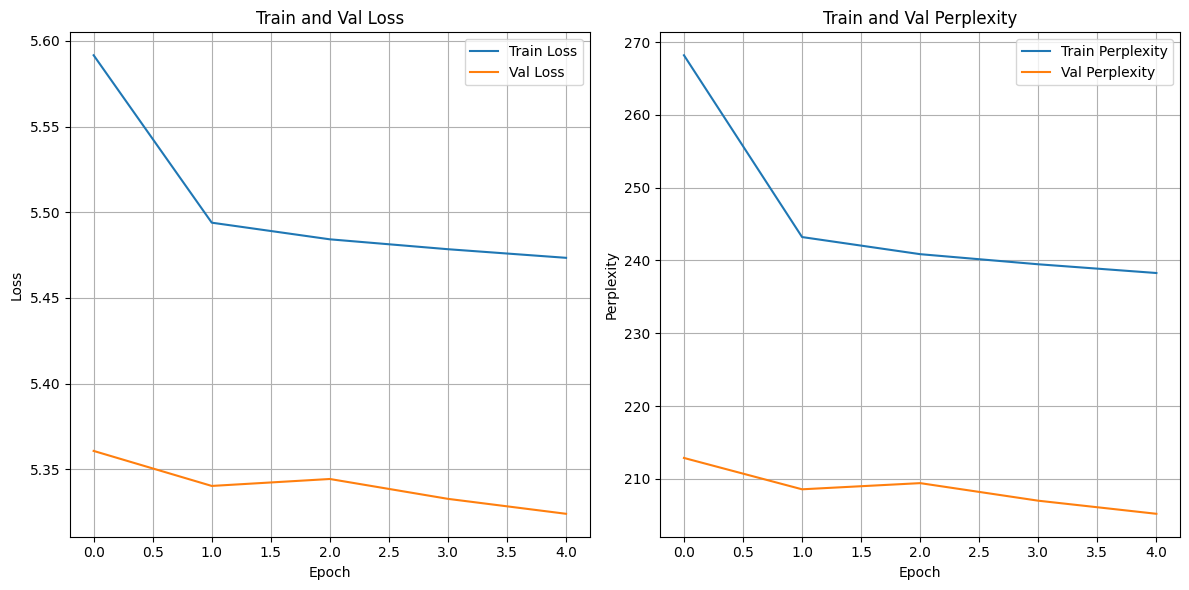

In [ ]:
plot_losses_and_perplexity(losses_train, losses_val, perplexities_train,
                           perplexities_val)  # plot losses and perplexity

# Exemplos de uso

In [ ]:
def generate_text(model, vocab, seed_text, max_length=20, device='cpu', context_size=5):
    """
    Gera texto a partir de um modelo de linguagem treinado.

    Args:
        model: modelo treinado (nn.Module)
        vocab: dicionário {token: id}
        seed_text: texto inicial (str)
        max_length: número máximo de palavras a gerar
        device: cpu ou cuda
        context_size: tamanho do contexto usado pelo modelo

    Returns:
        Texto gerado (str)
    """
    model.eval()
    model.to(device)
    id_to_token = {idx: tok for tok, idx in vocab.items()}

    # Tokeniza e converte seed_text para ids
    tokens = seed_text.strip().lower().split()
    context = [vocab.get(token, 0) for token in tokens[-context_size:]]

    # Preenche contexto se necessário
    if len(context) < context_size:
        context = [0] * (context_size - len(context)) + context

    generated = context.copy()

    for _ in range(max_length):
        x = torch.tensor([context], dtype=torch.long, device=device)
        with torch.no_grad():
            logits = model(x)
        next_id = torch.argmax(logits, dim=-1).item()
        generated.append(next_id)
        context = generated[-context_size:]

    # Converte ids para tokens, ignora <unk> se quiser
    result = [id_to_token.get(idx, '<unk>')
              for idx in generated if idx in id_to_token]
    return ' '.join(result)

In [ ]:
context = 5
max_length = 9
text = "Era uma dia belo de sol"
generate_text(model, tokenizer_tiny.vocab, text, max_length, device)

'[PAD] dia [PAD] de sol ##a , [SEP] ##z , [SEP] ##a [SEP] ##oi'

In [ ]:
text = "este é um texto gerado artificialmente"
generate_text(model, tokenizer_tiny.vocab, text, max_length, device)

'[PAD] um [PAD] [PAD] [PAD] , e [SEP] ##a [SEP] ##oi , [SEP] ##oi'

In [ ]:
text = "joana tentou muito e assim conseguiu"
generate_text(model,tokenizer_tiny.vocab,text, max_length,device,context_size=context)

'[PAD] [PAD] e [PAD] [PAD] . [SEP] ##a , [SEP] ##oi ##a [SEP] ##oi'